In [2]:
from YahooDownloader import YahooDownloader
from envs.MinimalStockTradingEnv2 import StockTradingEnv
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor

from FeatureEngineer import FeatureEngineer
from sklearn.model_selection import train_test_split
from pathlib import Path
import config
from pandas import read_csv

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
tickers = [
    "TCS.NS",
    "BAJFINANCE.NS",
    "BAJAJFINSV.NS",
    "BHARTIARTL.NS",
    "EICHERMOT.NS",
    "HDFCBANK.NS",
    "HINDUNILVR.NS",
]
fe_df = read_csv(f"datasets/{'-'.join(tickers)}-720d-1h.csv")
fe_df = fe_df.drop("Unnamed: 0", axis=1)
fe_df.index = fe_df.date.factorize()[0]
fe_df

,date,tic,close,high,low,open,volume,sma_30,sma_60,ema_8,ema_21,macd,rsi_14,dx_30,cci_30,boll_ub,boll_lb,boll_mid
0,2019-12-18 12:15:00,BAJAJFINSV.NS,1876.150024,1884.000000,1875.519897,1883.140015,25233.0,1853.952002,1824.644511,1873.542396,1861.573474,12.912927,69.609034,50.252900,129.044187,1884.358006,1870.452449,1877.405227
0,2019-12-18 12:15:00,BAJFINANCE.NS,4126.899902,4133.500000,4119.450195,4123.549805,91559.0,4071.535002,4028.172510,4112.718459,4085.804982,24.792539,68.962585,11.061192,160.536031,4143.223951,4114.591314,4128.907632
0,2019-12-18 12:15:00,BHARTIARTL.NS,437.299988,440.000000,437.250000,438.750000,1545931.0,430.943333,438.384166,435.253264,432.552239,0.787068,57.824659,3.500518,79.480580,441.355700,435.548953,438.452327
0,2019-12-18 12:15:00,EICHERMOT.NS,2152.064941,2157.229980,2142.649902,2147.899902,18753.0,2186.524992,2154.145581,2160.033402,2169.777424,-5.202947,38.384138,10.892939,-134.631553,2177.354219,2137.847371,2157.600795
0,2019-12-18 12:15:00,HDFCBANK.NS,1295.500000,1297.650024,1278.750000,1279.849976,4114558.0,1265.789998,1257.135000,1279.074452,1270.037958,7.165374,83.671941,45.439209,259.157823,1296.258510,1265.118977,1280.688743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,2022-10-28 10:15:00,BHARTIARTL.NS,815.400024,818.099976,813.349976,817.599976,413140.0,802.226668,788.805003,814.742986,807.647085,7.221318,64.507219,34.573356,108.055092,822.847142,813.396184,818.121663
4222,2022-10-28 10:15:00,EICHERMOT.NS,3761.000000,3764.000000,3741.000000,3752.000000,61289.0,3665.814982,3590.583317,3720.251126,3685.680901,34.234329,72.530377,30.095660,164.308415,3773.654087,3666.678562,3720.166325
4222,2022-10-28 10:15:00,HDFCBANK.NS,1460.800049,1465.800049,1459.599976,1464.300049,1018060.0,1452.056669,1448.582499,1457.591287,1454.761328,2.656448,55.927161,18.878109,124.591839,1465.751670,1449.230384,1457.491027
4222,2022-10-28 10:15:00,HINDUNILVR.NS,2540.050049,2550.899902,2535.350098,2539.000000,124474.0,2565.158333,2581.228333,2524.782993,2539.522802,-18.775108,47.315495,4.642782,-28.641859,2547.786139,2488.011714,2517.898927


In [18]:
test_size = 0.2
last_index = fe_df.index.values[-1]

test_size = int(test_size * last_index)
train_size = last_index - test_size
total = test_size + train_size

train = fe_df.loc[:train_size]
test = fe_df.loc[train_size+1:]


In [19]:
train

,date,tic,close,high,low,open,volume,sma_30,sma_60,ema_8,ema_21,macd,rsi_14,dx_30,cci_30,boll_ub,boll_lb,boll_mid
0,2019-12-18 12:15:00,BAJAJFINSV.NS,1876.150024,1884.000000,1875.519897,1883.140015,25233.0,1853.952002,1824.644511,1873.542396,1861.573474,12.912927,69.609034,50.252900,129.044187,1884.358006,1870.452449,1877.405227
0,2019-12-18 12:15:00,BAJFINANCE.NS,4126.899902,4133.500000,4119.450195,4123.549805,91559.0,4071.535002,4028.172510,4112.718459,4085.804982,24.792539,68.962585,11.061192,160.536031,4143.223951,4114.591314,4128.907632
0,2019-12-18 12:15:00,BHARTIARTL.NS,437.299988,440.000000,437.250000,438.750000,1545931.0,430.943333,438.384166,435.253264,432.552239,0.787068,57.824659,3.500518,79.480580,441.355700,435.548953,438.452327
0,2019-12-18 12:15:00,EICHERMOT.NS,2152.064941,2157.229980,2142.649902,2147.899902,18753.0,2186.524992,2154.145581,2160.033402,2169.777424,-5.202947,38.384138,10.892939,-134.631553,2177.354219,2137.847371,2157.600795
0,2019-12-18 12:15:00,HDFCBANK.NS,1295.500000,1297.650024,1278.750000,1279.849976,4114558.0,1265.789998,1257.135000,1279.074452,1270.037958,7.165374,83.671941,45.439209,259.157823,1296.258510,1265.118977,1280.688743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3378,2022-03-24 12:15:00,BHARTIARTL.NS,701.500000,703.700012,701.049988,701.450012,226797.0,712.505003,708.091668,704.830974,708.081822,-2.341869,37.571092,9.810307,-106.119014,708.777893,698.938709,703.858301
3378,2022-03-24 12:15:00,EICHERMOT.NS,2367.600098,2370.100098,2360.500000,2364.500000,60927.0,2390.153345,2354.282499,2375.200665,2378.438923,0.062354,46.369600,0.903397,-74.939059,2398.985846,2353.499191,2376.242518
3378,2022-03-24 12:15:00,HDFCBANK.NS,1436.250000,1448.500000,1435.000000,1448.500000,1677039.0,1479.701668,1455.436664,1461.438173,1471.179713,-3.444109,31.716458,9.409765,-261.222363,1488.473117,1431.582557,1460.027837
3378,2022-03-24 12:15:00,HINDUNILVR.NS,1974.099976,1979.000000,1971.000000,1973.949951,145686.0,2020.526672,2042.957503,1980.840950,1998.068779,-18.426820,33.411938,18.610396,-72.521637,1988.093473,1968.154283,1978.123878


In [20]:
test

,date,tic,close,high,low,open,volume,sma_30,sma_60,ema_8,ema_21,macd,rsi_14,dx_30,cci_30,boll_ub,boll_lb,boll_mid
3379,2022-03-24 13:15:00,BAJAJFINSV.NS,3279.000000,3286.039795,3268.260010,3270.800049,20263.0,3272.147347,3219.111169,3283.149859,3275.363259,13.221082,53.424120,11.089698,15.277780,3305.405445,3264.131099,3284.768272
3379,2022-03-24 13:15:00,BAJFINANCE.NS,6992.649902,7010.750000,6970.000000,6978.399902,84279.0,6962.059977,6835.478328,6996.164996,6971.387319,34.715595,55.683349,7.513051,38.101940,7040.207450,6967.203880,7003.705665
3379,2022-03-24 13:15:00,BHARTIARTL.NS,703.900024,704.299988,700.450012,701.500000,293139.0,711.750004,708.170001,704.624096,707.701658,-2.349223,42.442670,9.810307,-94.508739,708.021220,698.566481,703.293850
3379,2022-03-24 13:15:00,EICHERMOT.NS,2376.000000,2376.949951,2365.100098,2365.100098,61522.0,2387.791675,2355.731665,2375.378295,2378.217202,-0.056717,49.613288,1.029131,-51.192601,2381.825200,2363.973509,2372.899355
3379,2022-03-24 13:15:00,HDFCBANK.NS,1443.449951,1446.900024,1435.849976,1436.550049,984198.0,1478.278333,1456.087496,1457.440790,1468.658825,-5.081135,36.609760,9.409765,-206.000248,1471.521162,1433.645291,1452.583226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,2022-10-28 10:15:00,BHARTIARTL.NS,815.400024,818.099976,813.349976,817.599976,413140.0,802.226668,788.805003,814.742986,807.647085,7.221318,64.507219,34.573356,108.055092,822.847142,813.396184,818.121663
4222,2022-10-28 10:15:00,EICHERMOT.NS,3761.000000,3764.000000,3741.000000,3752.000000,61289.0,3665.814982,3590.583317,3720.251126,3685.680901,34.234329,72.530377,30.095660,164.308415,3773.654087,3666.678562,3720.166325
4222,2022-10-28 10:15:00,HDFCBANK.NS,1460.800049,1465.800049,1459.599976,1464.300049,1018060.0,1452.056669,1448.582499,1457.591287,1454.761328,2.656448,55.927161,18.878109,124.591839,1465.751670,1449.230384,1457.491027
4222,2022-10-28 10:15:00,HINDUNILVR.NS,2540.050049,2550.899902,2535.350098,2539.000000,124474.0,2565.158333,2581.228333,2524.782993,2539.522802,-18.775108,47.315495,4.642782,-28.641859,2547.786139,2488.011714,2517.898927


In [15]:
train, trade = train_test_split(fe_df, shuffle=False, test_size=0.20)

In [17]:
train

,date,tic,close,high,low,open,volume,sma_30,sma_60,ema_8,ema_21,macd,rsi_14,dx_30,cci_30,boll_ub,boll_lb,boll_mid
0,2019-12-18 12:15:00,BAJAJFINSV.NS,1876.150024,1884.000000,1875.519897,1883.140015,25233.0,1853.952002,1824.644511,1873.542396,1861.573474,12.912927,69.609034,50.252900,129.044187,1884.358006,1870.452449,1877.405227
0,2019-12-18 12:15:00,BAJFINANCE.NS,4126.899902,4133.500000,4119.450195,4123.549805,91559.0,4071.535002,4028.172510,4112.718459,4085.804982,24.792539,68.962585,11.061192,160.536031,4143.223951,4114.591314,4128.907632
0,2019-12-18 12:15:00,BHARTIARTL.NS,437.299988,440.000000,437.250000,438.750000,1545931.0,430.943333,438.384166,435.253264,432.552239,0.787068,57.824659,3.500518,79.480580,441.355700,435.548953,438.452327
0,2019-12-18 12:15:00,EICHERMOT.NS,2152.064941,2157.229980,2142.649902,2147.899902,18753.0,2186.524992,2154.145581,2160.033402,2169.777424,-5.202947,38.384138,10.892939,-134.631553,2177.354219,2137.847371,2157.600795
0,2019-12-18 12:15:00,HDFCBANK.NS,1295.500000,1297.650024,1278.750000,1279.849976,4114558.0,1265.789998,1257.135000,1279.074452,1270.037958,7.165374,83.671941,45.439209,259.157823,1296.258510,1265.118977,1280.688743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,2022-03-24 11:15:00,HDFCBANK.NS,1448.500000,1462.000000,1448.099976,1459.050049,1556352.0,1481.290002,1454.647498,1468.634794,1474.672684,-0.571486,36.121698,3.184819,-225.019523,1492.302576,1444.317946,1468.310261
3377,2022-03-24 11:15:00,HINDUNILVR.NS,1973.599976,1987.000000,1972.199951,1982.000000,374774.0,2024.290007,2045.088336,1982.766942,2000.465659,-18.724235,33.080205,18.226343,-71.917526,1988.294548,1970.901145,1979.597847
3377,2022-03-24 11:15:00,TCS.NS,3731.500000,3756.000000,3729.149902,3751.199951,246563.0,3684.986654,3655.937496,3723.849199,3700.120241,21.613823,62.465279,30.217328,133.520993,3761.242730,3701.616825,3731.429778
3378,2022-03-24 12:15:00,BAJAJFINSV.NS,3270.800049,3284.000000,3268.000000,3282.600098,19586.0,3272.421021,3216.686670,3284.335533,3274.999585,14.641680,51.100918,10.639686,4.195399,3310.559627,3266.263662,3288.411645


In [3]:
# Create Dirs
for dir in config.DIRS:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [4]:
tickers = ["TCS.NS", "BAJFINANCE.NS", "INTELLECT.NS"]
df = YahooDownloader(tickers=tickers, interval="1h", period="150d").process()
df

[*********************100%***********************]  3 of 3 completed
Shape of DataFrame: (3129, 7)


,date,tic,close,high,low,open,volume
0,2022-03-21 09:15:00,BAJFINANCE.NS,6956.850098,7018.450195,6933.600098,7000.000000,0
1,2022-03-21 09:15:00,INTELLECT.NS,782.650024,787.000000,766.250000,773.099976,0
2,2022-03-21 09:15:00,TCS.NS,3673.899902,3713.850098,3673.449951,3695.000000,0
3,2022-03-21 10:15:00,BAJFINANCE.NS,6963.950195,6980.000000,6935.549805,6956.850098,87325
4,2022-03-21 10:15:00,INTELLECT.NS,782.000000,784.500000,780.000000,782.650024,41060
...,...,...,...,...,...,...,...
3124,2022-10-25 14:15:00,INTELLECT.NS,501.000000,503.899994,500.500000,502.149994,47141
3125,2022-10-25 14:15:00,TCS.NS,3162.949951,3175.699951,3160.850098,3174.449951,321442
3126,2022-10-25 15:15:00,BAJFINANCE.NS,7097.000000,7106.000000,7091.350098,7104.000000,74685
3127,2022-10-25 15:15:00,INTELLECT.NS,500.600006,501.450012,499.700012,500.649994,41452


In [5]:
fe_df = FeatureEngineer(df=df, tickers=tickers).process()
fe_df

,date,tic,close,high,low,open,volume,sma_30,sma_60,ema_8,ema_21,macd,rsi_14,dx_30,cci_30,boll_ub,boll_lb,boll_mid
0,2022-03-31 12:15:00,BAJFINANCE.NS,7287.000000,7334.299805,7246.950195,7309.000000,306003.0,7095.668327,7028.589160,7282.546223,7187.308088,88.709540,63.852680,24.703069,98.830327,7435.715967,7233.083838,7334.399903
0,2022-03-31 12:15:00,INTELLECT.NS,936.650024,939.900024,927.000000,928.000000,159986.0,886.408333,856.692501,922.641316,903.746601,19.408992,79.674931,58.062687,112.865576,941.619068,910.730697,926.174882
0,2022-03-31 12:15:00,TCS.NS,3751.899902,3753.899902,3748.000000,3749.899902,197402.0,3712.449984,3704.049984,3738.946678,3724.824252,12.076616,64.851136,30.275875,161.760888,3758.648558,3729.815670,3744.232114
1,2022-03-31 13:15:00,BAJFINANCE.NS,7288.000000,7298.000000,7261.000000,7289.950195,96660.0,7106.148324,7034.108325,7283.758173,7196.461899,85.186789,63.930774,24.703069,87.183722,7412.284839,7251.721238,7332.003038
1,2022-03-31 13:15:00,INTELLECT.NS,930.000000,942.549988,925.849976,936.650024,189230.0,889.100000,859.148334,924.276579,906.133274,19.038708,72.697410,58.685925,102.699845,937.035298,920.851018,928.943158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2022-10-25 14:15:00,INTELLECT.NS,501.000000,503.899994,500.500000,502.149994,47141.0,512.545002,519.245835,505.027139,509.602078,-4.197269,23.667739,19.504416,-173.638010,506.754283,500.889943,503.822113
853,2022-10-25 14:15:00,TCS.NS,3162.949951,3175.699951,3160.850098,3174.449951,321442.0,3144.891675,3126.399166,3161.903750,3151.364514,9.925626,58.250198,10.813366,122.049821,3177.961769,3155.621676,3166.791723
854,2022-10-25 15:15:00,BAJFINANCE.NS,7097.000000,7106.000000,7091.350098,7104.000000,74685.0,7284.933333,7275.175830,7139.889665,7212.908427,-61.311282,29.637174,27.910452,-130.564833,7142.351326,7071.585563,7106.968444
854,2022-10-25 15:15:00,INTELLECT.NS,500.600006,501.450012,499.700012,500.649994,41452.0,511.756669,518.965001,504.043332,508.783708,-4.372902,23.185646,20.543855,-183.502326,505.164711,499.749757,502.457234


In [6]:
fe_df.to_csv("datasets/fe-df-tcs-bajfinance-intellect-1h-150d.csv")

In [7]:
# make sure test_size is always even
train, trade = train_test_split(fe_df, shuffle=False, test_size=0.20)

print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(trade)}")

Number of training samples: 2052
Number of testing samples: 513


## how state_space is calculated -
1 = [HMAX]</br>
2 * STOCK_DIMENSION = ["DATE", "CLOSE"] * len(TICKERS)</br>
(len(tech_indicator_list) * NumOfTickers) = len(['sma_30', 'sma_60', 'ema_8', 'ema_21', 'macd', 'rsi_30', 'rsi_70','dx_30', 'cci_30', 'boll_ub', 'boll_lb']) * len(TICKERS)</br>

In [8]:
e_train_gym = StockTradingEnv(df=train, tickers=tickers)
e_trade_gym = StockTradingEnv(df=trade, tickers=tickers)

In [25]:
from callbacks.SaveOnBestTrainingRewardCallback import (
    SaveOnBestTrainingRewardCallback,
    TensorboardCallback,
)
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO

e_train_gym = StockTradingEnv(df=train, tickers=tickers)
e_trade_gym = StockTradingEnv(df=trade, tickers=tickers)

set_random_seed(0)
logger = configure("logs", ["stdout", "csv", "tensorboard"])
model_ppo = PPO(
    policy="MlpPolicy",
    env=e_train_gym,
    verbose=1,
    tensorboard_log="tensorboard_log",
    n_steps=2048,
    ent_coef=0.01,
    learning_rate=0.00025,
    batch_size=64,
)
model_ppo.set_logger(logger)
model_ppo.learn(
    total_timesteps=5000,
    callback=TensorboardCallback(),
)

Logging to logs
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs
self.index=683
self.index=683
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 684      |
|    ep_rew_mean     | -2.18    |
| time/              |          |
|    fps             | 354      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.0      |
---------------------------------
self.index=683
self.index=683
self.index=683
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 684           |
|    ep_rew_mean          | -2.1          |
| time/                   |               |
|    fps                  | 284           |
|    iterations           | 2             |
|    time_elapsed         | 14            |
|    total_timesteps      | 4096      

In [26]:
model_ppo.save("results/ppo")

In [27]:
obs = e_trade_gym.reset()
for i in range(e_trade_gym.df.shape[0]):
    action, _states = model_ppo.predict(obs, deterministic=True)
    obs, rewards, done, info = e_trade_gym.step(action)
    if done:
        break
    print(f"{rewards=}")

rewards=-4.26849365234375e-05
rewards=-4.3426513671875e-05
rewards=-4.3133544921875e-05
rewards=-4.295654296875e-05
rewards=-4.2529296875000005e-05
rewards=-4.2041015625000005e-05
rewards=-4.1943359375e-05
rewards=-4.24560546875e-05
rewards=-4.267578125e-05
rewards=-4.1748046875e-05
rewards=-4.140625e-05
rewards=-4.033203125e-05
rewards=-4.0625000000000005e-05
rewards=-4.052734375e-05
rewards=-3.876953125e-05
rewards=-3.90625e-05
rewards=-3.9892578125000004e-05
rewards=-3.9990234375e-05
rewards=-4.033203125e-05
rewards=-3.9111328125e-05
rewards=-3.9453125000000005e-05
rewards=-3.994140625e-05
rewards=-3.955078125e-05
rewards=-3.9648437500000004e-05
rewards=-4.00390625e-05
rewards=-4.033203125e-05
rewards=-4.0625000000000005e-05
rewards=-3.974609375e-05
rewards=-3.974609375e-05
rewards=-3.9648437500000004e-05
rewards=-3.994140625e-05
rewards=-3.984375e-05
rewards=-3.974609375e-05
rewards=-3.974609375e-05
rewards=-3.974609375e-05
rewards=-3.984375e-05
rewards=-3.994140625e-05
rewards=-3.

In [119]:
account_memory = []
actions_memory = []
obs = e_trade_gym.reset()


for i in range(len(e_trade_gym.df.index.unique())):
    action, _states = trained_a2c.predict(obs, deterministic=True)
    obs, rewards, done, info = e_trade_gym.step(action)
    if i == (len(e_trade_gym.df.index.unique()) - 2):
        account_memory = e_trade_gym.env_method(method_name="save_asset_memory")
        actions_memory = e_trade_gym.env_method(method_name="save_action_memory")    
    # if done:
    #     print(f"{i} the end")
    #     break
account_memory, actions_memory

AttributeError: 'StockTradingEnv1' object has no attribute 'env_method'

In [108]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, environment=e_trade_gym
)
df_account_value_a2c

AttributeError: 'StockTradingEnv1' object has no attribute 'get_sb_env'

In [28]:
df_actions_a2c

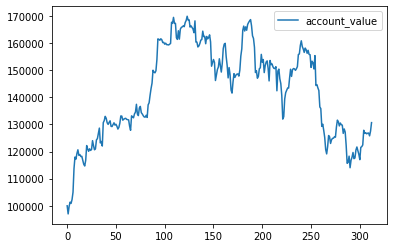

In [23]:
df_account_value_a2c.plot()
plt.show()

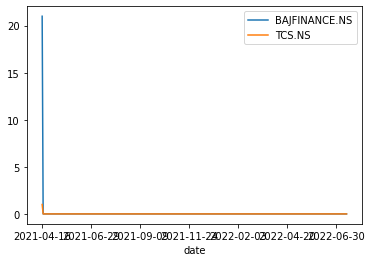

In [24]:
df_actions_a2c.plot()
plt.show()

In [29]:
from plot import backtest_stats

backtest_stats(df_account_value_a2c)

Annual return          0.240147
Cumulative returns     0.306471
Annual volatility      0.321163
Sharpe ratio           0.832694
Calmar ratio           0.730631
Stability              0.015074
Max drawdown          -0.328685
Omega ratio            1.161010
Sortino ratio          1.221260
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.076047
Daily value at risk   -0.039401
dtype: float64


c:\Users\Dhruv\AppData\Local\Programs\Python\Python38\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Annual return          0.240147
Cumulative returns     0.306471
Annual volatility      0.321163
Sharpe ratio           0.832694
Calmar ratio           0.730631
Stability              0.015074
Max drawdown          -0.328685
Omega ratio            1.161010
Sortino ratio          1.221260
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.076047
Daily value at risk   -0.039401
dtype: float64